In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import sys
import os

# Add the project root to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scripts.helper_scripts as helper_scripts
import scripts.setup_data as setup_data

In [15]:
df = pd.read_csv('../data/final.csv')
df, _ = setup_data.filter_and_prepare_data(df)

/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_correlated_errors/scripts/setup_data.py:154: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[col] = pd.to_numeric(scores_df[col], errors="coerce")
/Users/ElliotKim/Desktop/Cornell/LLM Markets/llm_correlated_errors/scripts/setup_data.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_df[cols_to_fill] = scores_df[cols_to_fill].apply(


In [27]:
# Select relevant LLM score columns
llmscorecols = [x for x in df.columns if x not in ['index', 'Job', 'job_cluster', 'Resume', 'resume_cluster','Resume_index', 'Job_index']]
llmscorecols_todo = [x for x in llmscorecols if (('comb2' in x) or ('Hand_firm_rate_comb' in x) or ('JobScan' in x)) and 'Hand' not in x]
dfcorr = df[llmscorecols_todo + ['Hand_firm_rate_comb']].corr()

#each model's corr with Hand_firm_rate_comb
dfmodels = dfcorr['Hand_firm_rate_comb'].reset_index().rename(columns = {'index':'model', 'Hand_firm_rate_comb':'correlation_with_human_score'}).sort_values(
    'correlation_with_human_score', ascending = False).query('model != "Hand_firm_rate_comb"')
# add column for latest model by company
latest_models = ['Llama3-3-70b_firm_rate_comb2', 'Mistral-Large_firm_rate_comb2', 'Nova-Pro_firm_rate_comb2', 'Claude_3.5_Sonnet(20241022)_firm_rate_comb2', 'Gpt-4o-mini_firm_rate_comb2']

dfmodels['latest_model'] = dfmodels['model'].apply(lambda x: x in latest_models)

#get company of model from model name
company_keywords = ['Llama', 'Mistral', 'Nova', 'Claude', 'Gpt']
dfmodels['company'] = dfmodels['model'].apply(lambda x: [y for y in company_keywords if y in x][0])

dfreg= df[llmscorecols_todo].corr()

#pivot dfreg so that each row is a pair of models, with a column for "correlation" that is the value of the correlation between the two models
dfreg = dfreg.reset_index().melt(id_vars = 'index').rename(columns = {'index':'model1', 'variable':'model2', 'value':'correlation'})
#remove rows where model1 == model2
dfreg = dfreg.query('model1 != model2')

dfresid = df.copy()
for col in llmscorecols_todo:
    dfresid[col] = dfresid[col] - dfresid['Hand_firm_rate_comb']
    
dfcorr_resid = dfresid[llmscorecols_todo].corr()

dfreg_resid = dfcorr_resid.reset_index().melt(id_vars = 'index').rename(columns = {'index':'model1', 'variable':'model2', 'value':'error_correlation'})
dfreg_resid = dfreg_resid.query('model1 != model2')

dfreg = dfreg.merge(dfreg_resid, on = ['model1', 'model2'])
dfreg['model1'], dfreg['model2'] = np.where(dfreg['model1'] < dfreg['model2'], [dfreg['model1'], dfreg['model2']], [dfreg['model2'], dfreg['model1']])
duplicates = dfreg.duplicated(subset=['model1', 'model2'], keep=False)

dfpairclean = dfreg.drop_duplicates(subset=['model1', 'model2'], keep='first')
dfreg = dfpairclean

df_switched = dfreg.copy()
np.random.seed(123)  # For reproducibility
switch_mask = np.random.rand(len(df_switched)) > 0.5
df_switched.loc[switch_mask, ['model1', 'model2']] = df_switched.loc[switch_mask, ['model2', 'model1']].values
dfreg = df_switched

dfreg = dfreg.merge(dfmodels, left_on = 'model1', right_on = 'model', how = 'left').drop(columns = 'model').rename(columns = {'correlation_with_human_score':'correlation_with_human_score_1', 'latest_model':'latest_model_1', 'company':'company_1'})

dfreg = dfreg.merge(dfmodels, left_on = 'model2', right_on = 'model', how = 'left').drop(columns = 'model').rename(columns = {'correlation_with_human_score':'correlation_with_human_score_2', 'latest_model':'latest_model_2', 'company':'company_2'})

dfreg['same_company'] = dfreg['company_1'] == dfreg['company_2']
dfregforcorr = dfreg.copy()
dfregforcorr = dfregforcorr.rename(columns = {'model1' : 'model_1', 'model2' : 'model_2'})

# remove _firm_rate_comb2 from model names
dfregforcorr['model_1'] = dfregforcorr['model_1'].str.replace('_firm_rate_comb2', '')
dfregforcorr['model_2'] = dfregforcorr['model_2'].str.replace('_firm_rate_comb2', '')

### Code to generate Table 8, 9 (Appendix C.3. Resumes)

In [28]:
y_values = ['correlation', 'error_correlation']
features = [
    'same_company',
    'latest_model_1',
    'latest_model_2',
    'correlation_with_human_score_1',
    'correlation_with_human_score_2',
]
dfstandard = dfreg.copy()
features_to_standardize = [
    'correlation_with_human_score_1',
    'correlation_with_human_score_2']

#standardize the numeric columns 
for col in features_to_standardize:
    if dfstandard[col].dtype == 'float64':
        dfstandard[col] = (dfstandard[col] - dfstandard[col].mean()) / dfstandard[col].std()
for y in y_values:
    helper_scripts.run_and_show_regression(y, features + ['correlation_with_human_score_1*correlation_with_human_score_2'], df=dfstandard, datasetname = 'markets')

                            OLS Regression Results                            
Dep. Variable:            correlation   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     262.8
Date:                Thu, 29 May 2025   Prob (F-statistic):           3.96e-87
Time:                        00:03:42   Log-Likelihood:                 304.07
No. Observations:                 190   AIC:                            -594.1
Df Residuals:                     183   BIC:                            -571.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Code to generate Table 10 (Appendix D)

In [18]:
dfmodels.sort_values(['company', 'correlation_with_human_score'], ascending = [True, False])

,model,correlation_with_human_score,latest_model,company
16,Claude_3.5_Sonnet(20241022)_firm_rate_comb2,0.713037,True,Claude
15,Claude_3.5_Haiku(20241022)_firm_rate_comb2,0.657761,False,Claude
14,Claude_3_Haiku(20240307)_firm_rate_comb2,0.343075,False,Claude
17,Gpt-o1-mini_firm_rate_comb2,0.704777,False,Gpt
18,Gpt-4o-mini_firm_rate_comb2,0.681016,True,Gpt
19,Gpt-3.5-turbo_firm_rate_comb2,0.297474,False,Gpt
5,Llama3-1-405b_firm_rate_comb2,0.671870,False,Llama
10,Llama3-3-70b_firm_rate_comb2,0.668421,True,Llama
4,Llama3-2-90b_firm_rate_comb2,0.643906,False,Llama
2,Llama3-1-70b_firm_rate_comb2,0.627783,False,Llama


### Code to generate Figure 9a, 9b (Appendix B)

0
0


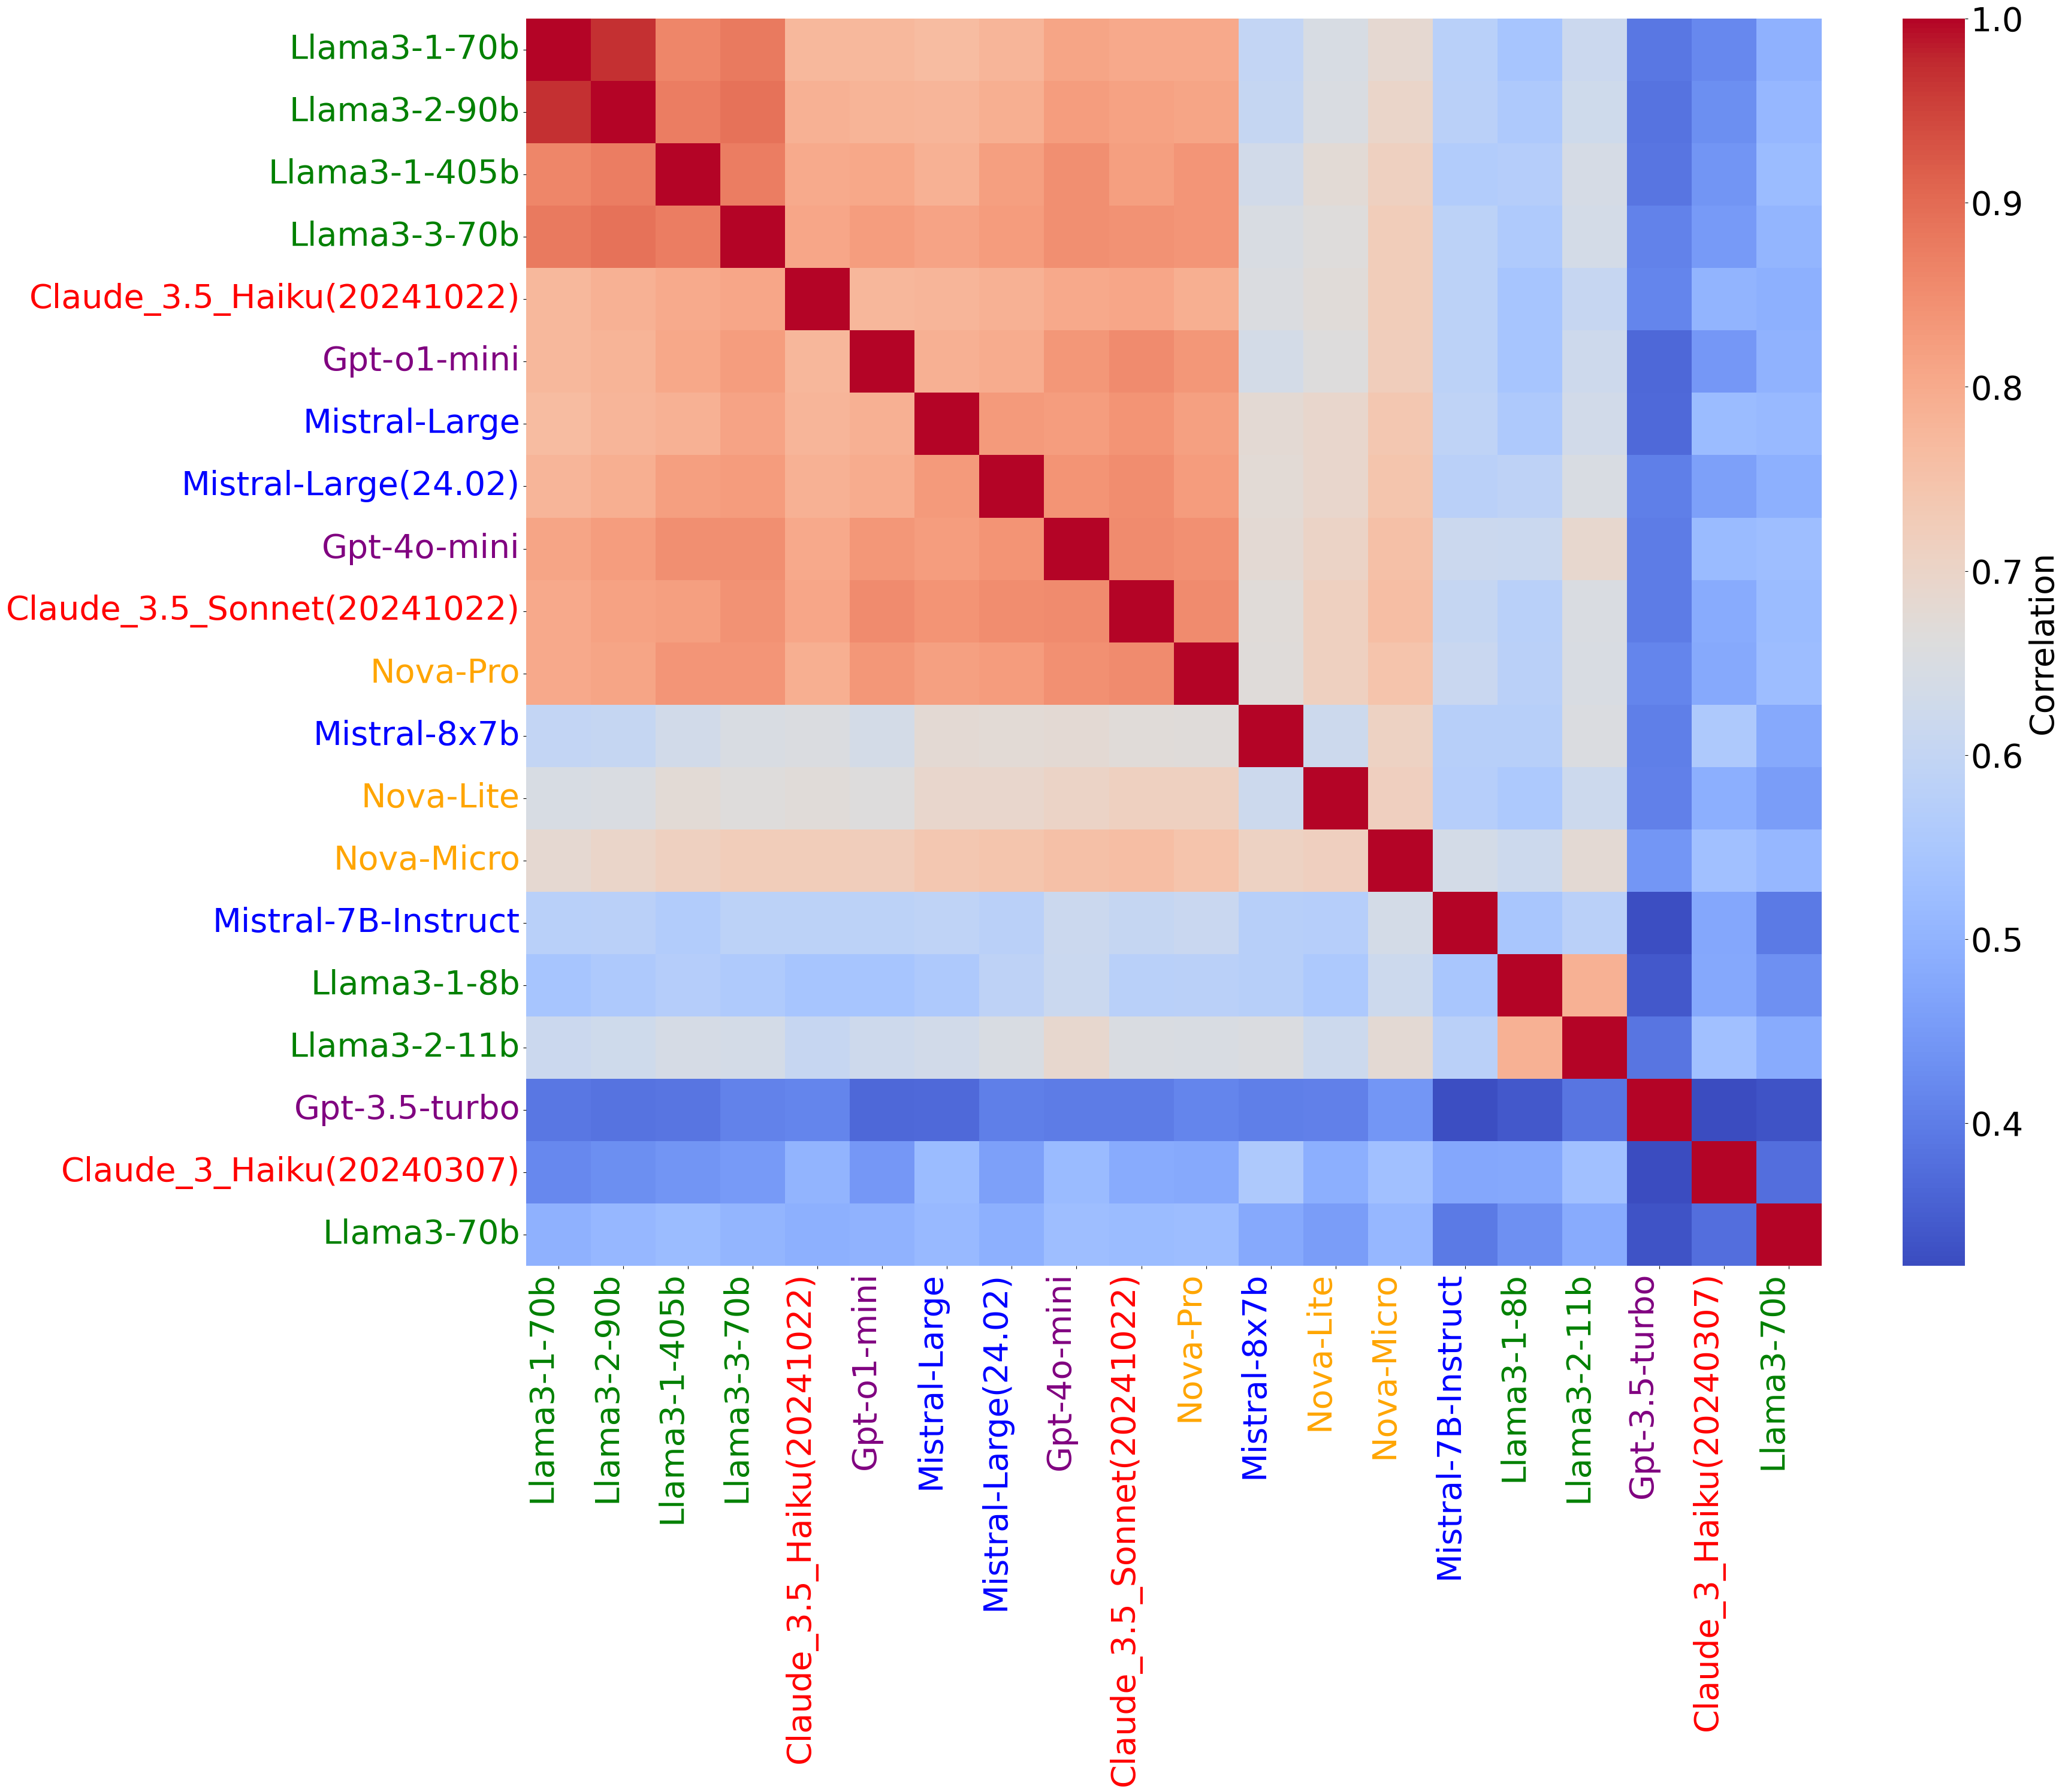

In [19]:
helper_scripts.plot_heatmap(df = dfregforcorr, col = 'correlation', order_with_clustermap = True, fontsize = 40, save = True, savename = 'marketcorrelation')

0
0


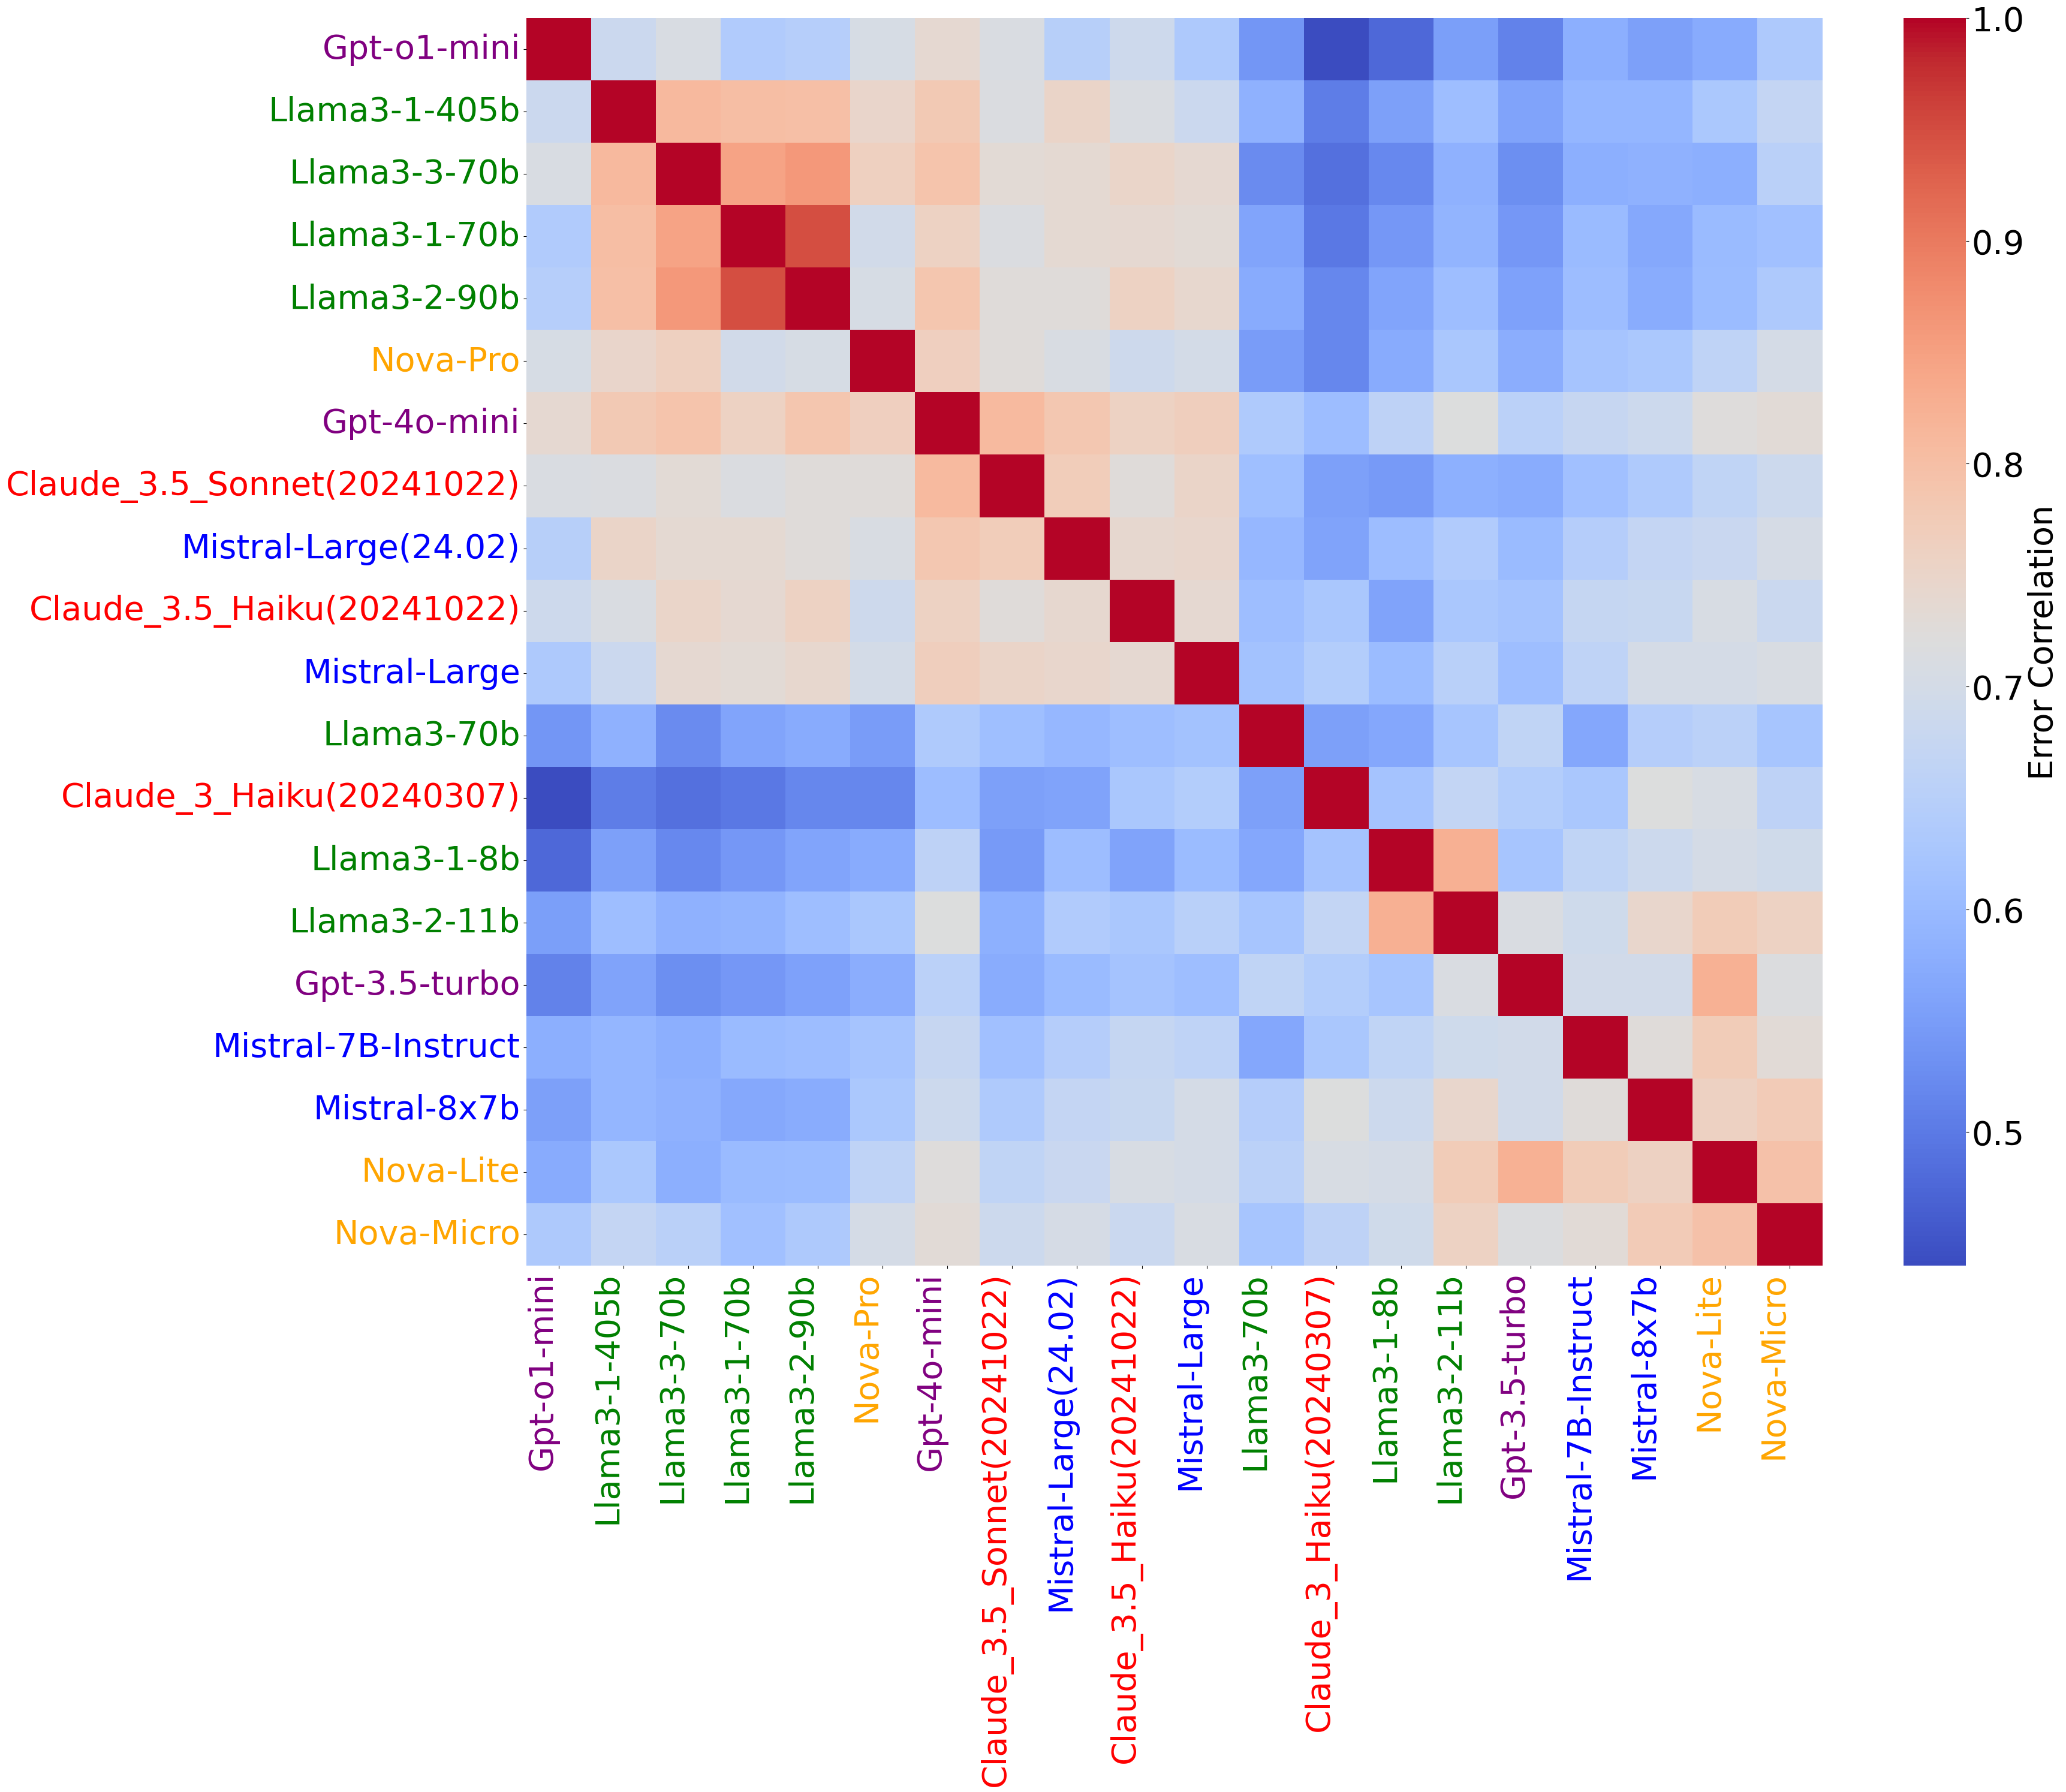

In [20]:
helper_scripts.plot_heatmap(df = dfregforcorr, col = 'error_correlation', order_with_clustermap = True, fontsize = 40, save = True, savename = 'marketcorrelation')